<a href="https://colab.research.google.com/github/CourageousGoofy/Market_Timing/blob/master/Volatility_Timing_VIX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 **Strategy Backtest. 
 Assume a long-only portfolio with leverage, adjusting net exposure based on market 'fear' level. Bechmark is a simply buy-and-hold portfolio.**
 
Reference voalitlity Index:\
VXO - SP100 voaltility index\
VIX - SP 500 volatility index\
RVX - R2000 voalitliy index\
\
Coding reference:\
https://stackoverflow.com/questions/26886653/pandas-create-new-column-based-on-values-from-other-columns


VIX moving average period: act as a singal delay\
i.e. wait till market has fell for a bit then add up exposure\
VIX requires a time to build up.. so when it reached certain threshold, stocks price has been down by some %\

Reduce MA period, i.e. set signal line as 3-day MV or 2-day MV. \
When ‘n’ is too large, might miss the opportunity as VIX is unlikely to sustain at high level\
before trim down exposure, wait till market bounce a bit\
we may add in a screw coefficiet\
i.e. it takes markets 5 days to tumble but 10 days to catch up\
\
\
**NEXT STEP - combine with SMA cross

In [0]:
import pandas as pd
from pandas import DataFrame as df
import numpy as np
from pandas_datareader import data
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


tickers = ['SHV', '^VIX','SPY']
# ORDER MATTERS, for flexibility reason
# tickers = ['low risk asset', 'volatility index', 'risky asset']
# '^VXO' - CBOE s&p 100 volatiltiy index
# 'SHV' - ishares short-term bond ETF, duration < 1yr
start= '2009-12-31'
end = '2019-4-30'
# Data sources can be yahoo, morning star, etc. 
price = data.DataReader(tickers,'yahoo',start,end)['Adj Close']
price_adj = price.fillna(method='ffill')

# price_LQD = dat[('Adj Close','LQD')]
# XCS.to_csv("XCS.csv") #XCS = pd.read_csv("test_data.csv")


**Backtest**\
\
**Part 1 - Strategy**

At qucik look at VIX percentile

[11.68000031 14.06000042 17.20000076 24.79000092 30.71999931]
[24.79000092 30.71999931 36.33000183 42.03750038 54.65000057]
Date
2009-12-31    92.561058
2010-01-04    94.130867
2010-01-05    94.380074
2010-01-06    94.446495
2010-01-07    94.845207
Name: SPY, dtype: float64


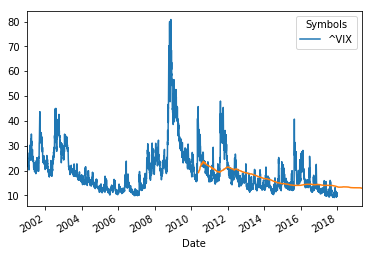

In [0]:
# Parameters (some will need to be optimized)
# a longer historical period to visualize VIX spikes
start_k1 = '2000-12-31'
end_k1 = '2017-12-31'
# a shorter hisotrical period to determine 'low' VIX levels
k2 = 750 #i.e. 3 years
# a longer hisotrical period to determine 'high' VIX levels
k3 = 1250 #i.e. 5 years
# holding period once we increased exposure. 'singal_rolling_max' period. 
t1 = 126 #i.e. 6 months
# SMA days for recent VIX level, 'vix_sma_st' is use for assessing recent market mood
t2 = 30 
# VIX percentile threshold, a signal that market calms down
p_calm = 0.5

# look back period for max asset price
t3 = 90


# visualize data
vix_ticker = ['^VIX'] 
vix_hist = data.DataReader(vix_ticker,'yahoo',start_k1,end_k1)['Adj Close']
vix_hist = vix_hist.fillna(method='ffill')
vix_hist.plot()
print(np.percentile(vix_hist, q = [10,30,50,80,90]))
print(np.percentile(vix_hist, q = [80,90,95,97,99]))

# VIX SMA
vix = price_adj["^VIX"]
vix_sma_5 = price["^VIX"].rolling(5).mean()
vix_sma_st = price["^VIX"].rolling(t2).mean()

# VIX percentile threshold
vix_20 = vix.rolling(k3).quantile(0.2, interpolation = 'midpoint').dropna()
vix_60 = vix.rolling(k3).quantile(0.5, interpolation = 'midpoint').dropna()
vix_90 = vix.rolling(k3).quantile(0.9, interpolation = 'midpoint').dropna()
vix_95 = vix.rolling(k3).quantile(0.95, interpolation = 'midpoint').dropna()
vix_99 = vix.rolling(k3).quantile(0.99, interpolation = 'midpoint').dropna()
vix_calm = vix.rolling(k2, min_periods = 100).quantile(p_calm, interpolation = 'midpoint').dropna()
vix_calm.plot()

# ETF price

asset_price = price_adj.iloc[:,1]
asset_price.columns = ['asset price']
asset_previous_high = asset_price.rolling(t3,min_periods = 10).max()

print(asset_price.head())


**Singal - Version 1**

In [0]:
# define factor dataframe
factors = pd.concat([vix, vix_90, vix_95, vix_99, vix_20, vix_60], axis=1)
factors.columns = ['vix','vix90','vix95','vix99', 'vix20','vix60']
factors = factors.dropna()

# define signal function
# reduce net exposure as VIX goes down (buy when others fear!)

# Version 1 - dynamic
def add_weight_dynamic(factors):
  if factors['vix'] > factors['vix99']:
    return 2.5
  elif factors['vix'] > factors['vix95']:
    return 1.5
  elif  factors['vix'] > factors['vix20']: 
    return 0.5
  return 0.33

**Signal - Version 2**\
Inputs:
1. vix level
2. price level

In [0]:
# define factor dataframe
factors = pd.concat([vix, vix_sma_st, vix_calm, asset_price, asset_previous_high], axis=1)
factors.columns = ['vix','vix_sma_st','vix_calm','asset_price','asset_price_high']
factors = factors.dropna()

# Version 2 - fixed 
def add_weight_fix(factors):
  if factors['vix'] > 35:
    return 2
  elif factors['vix'] > 30:
    return 1.5
  elif factors['vix'] > 25:
    return 1.25


**Rebalancing**

In [0]:
# add 'signal' column (CHOOSE WHICH SIGNAL TO USE)
factors['signal'] = factors.apply(add_weight_fix, axis=1)
# add rolling_max column - hold for a while once increased weight
factors['singal_rolling_max'] = factors['signal'].rolling(t1).max()


# Define Rebalance Rules
def rebalance(factors):
  if factors['vix_sma_st'] < factors['vix_calm'] or factors['asset_price'] > factors['asset_price_high']*0.99:
    return factors['signal']
  return factors['singal_rolling_max']


# add 'target position' column - positoins to be at the eod (end of day)
factors['target_position'] = factors.apply(rebalance, axis=1)
factors = factors.dropna()

# add 'actual position'
# positions at the start of the trading day, equal to previous day's eod position
factors['actual_position'] = factors['target_position'].shift(periods=1, axis='index')
factors = factors.dropna()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [0]:
print(factors.head(20))
print(factors.tail(20))
#print (factors.iloc[:,5:])
#print(price_adj)
#print(pd.concat([spy, spy_fwd, price['SPY']], axis=1))


**Part 2 - Performance Metrics**

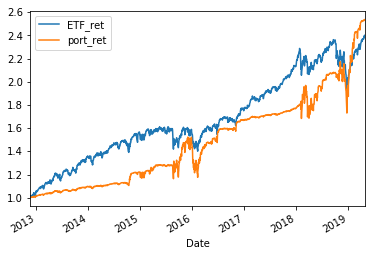

In [0]:
# 1-day forward 1-day return
spy = price['SPY'].pct_change()
spy_fwd = spy.shift(periods=-1, axis='index')
spy_fwd.fillna(0)
spy_fwd.columns = ["return"]

return_series = pd.concat([factors['actual_position'], spy], axis=1).dropna()
return_series.columns = ['actual_position','ETF_ret']                    

return_series["port_ret"] = return_series['actual_position'] * return_series["ETF_ret"]

ts = return_series[["ETF_ret", "port_ret"]]+1 #gross returns benchmark vs. portfolio
cum_ts = ts.cumprod()
cum_ts.plot()

factors_diagnostics = factors
factors_diagnostics['spy price'] = price_adj['SPY']


In [0]:
#print(return_series.head(10))
print(return_series.actual_position.head(10))
print(return_series.actual_position.tail(10))



Date
2010-12-29    0.3
2010-12-30    0.3
2010-12-31    0.3
2011-01-03    0.3
2011-01-04    0.3
2011-01-05    0.3
2011-01-06    0.3
2011-01-07    0.3
2011-01-10    0.3
2011-01-11    0.3
Name: actual_position, dtype: object
Date
2019-04-16    <bound method Rolling.max of Rolling [window=1...
2019-04-17    <bound method Rolling.max of Rolling [window=1...
2019-04-18    <bound method Rolling.max of Rolling [window=1...
2019-04-22    <bound method Rolling.max of Rolling [window=1...
2019-04-23    <bound method Rolling.max of Rolling [window=1...
2019-04-24    <bound method Rolling.max of Rolling [window=1...
2019-04-25    <bound method Rolling.max of Rolling [window=1...
2019-04-26    <bound method Rolling.max of Rolling [window=1...
2019-04-29    <bound method Rolling.max of Rolling [window=1...
2019-04-30    <bound method Rolling.max of Rolling [window=1...
Name: actual_position, dtype: object



Daily Return/Risk/Skew Profile

In [0]:
ret_daily = price.pct_change(periods = 1) 
rolling_period = 60
std_roll = ret_daily.rolling(rolling_period).std()
ret_roll = price.pct_change(periods = rolling_period)
skew_roll = ret_daily.rolling(500).skew()
print(skew_roll)
std_roll.plot()
ret_roll.plot()
skew_roll.plot()


# Rolling Profile
n = 10 # set return periods
ret = price.pct_change(periods = n)
skew_roll = vix.rolling(500).skew()
skew_roll.plot()
print(skew_roll)

SMA Backtest

In [0]:
short_period = 21
long_period = 50

price_xiu = price['XIU.TO']
smas = price_xiu.rolling(short_period).mean()
smal = price_xiu.rolling(long_period).mean()
signal = (((smas - smal)>0)*1-0.5)*2

print(signal)
print(signal.isna().sum())

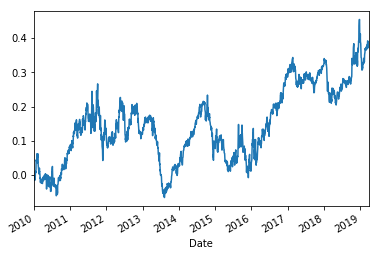

In [0]:
sim_ret = signal*ret_daily['XIU.TO']
gross_sim_ret = sim_return + 1 
cum_sim_ret = gross_sim_ret.cumprod()-1
#print(sim_return)
#print(cum_sim_ret)
cum_sim_ret.plot()

In [0]:
#var = ret.var(axis=0)
#print(var)
#std = ret.std(axis=0)
#print(std)


Risk Budgeting Framework

In [0]:
from scipy.optimize import minimize

w0 = [0.2, 0.6, 0.2] # initial weight
V = cov # covariance matrix
TRC = [0.25, 0.5, 0.25] # target risk contr. as % of inital portfolio vol 

cons = ({'type': 'eq', 'fun': total_weight_constraint},
        {'type': 'ineq', 'fun': long_only_constraint}) # 'ineq'constraint by default means non-negative
res= minimize(risk_objective_function, w0, args=[cov, TRC], method='SLSQP',constraints=cons, options={'disp': True})
w_rb = np.asmatrix(res.x)

TypeError: ignored

matrix([[ 0.02084394],
        [-0.04264155],
        [ 0.02104696]])